In [1]:
#meta 6/20/2021 myCassava Image Classifier w/ TFHub Pre-Trained Model (w/o Internet)
#Predict on test data using saved pre-trained Cassava disease classification model 
#hybrid: (data) Kaggle competition + (code) Hub example Cropnet-Cassava
#ref
# src https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/cropnet_cassava.ipynb
# src code Github https://github.com/tensorflow/hub/blob/master/examples/colab/cropnet_cassava.ipynb
# src code https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/saved_model.ipynb#scrollTo=NP2UpVFRV7N_

#input: Kaggle competition test image and real test images
#output: A probability vector of of 6 cassava classes
#based on my-cropnet-cassava.ipynb (w/ Internet access) 


#previously in my-cropnet-cassava.ipynb (w/ Internet access) 
#6/6/2021 IMAGE CLASSIFIER w/PRETRAINED MODEL (W/ BATCHING)
#     Predict on a larger subset of train images (10%)
#     Split ds into batches,BS=128
#     Refer to: [Tensorflow 2.0] Load Pandas dataframe to Tensorflow
#     src https://financial-engineering.medium.com/tensorflow-2-0-load-pandas-dataframe-to-tensorflow-202c5d48966b
#     Accuracy ~88.27% 
#
#     Split ds into smaller batches,BS=64
#     Same Accuracy ~88.27% 
#6/20/2021 IMAGE CLASSIFIER w/PRETRAINED MODEL - PREDICT ON TEST DATA
#     Predict on test dataset
#     Prep for Kaggle submission - doesn't work with Internet enabled
#
#related ref
#src https://financial-engineering.medium.com/tensorflow-2-0-load-images-to-tensorflow-897b8b067fc2


#history
#6/20/2021 IMAGE CLASSIFIER w/PRETRAINED MODEL - PREDICT ON TEST DATA W/O INTERNET
#     Use saved model
#     Predict on test dataset
#     Submit to Kaggle submission


In [2]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# CropNet: Cassava Disease Detection

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/cropnet_cassava"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/cropnet_cassava.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/cropnet_cassava.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/cropnet_cassava.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/cropnet/classifier/cassava_disease_V1/2"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

This notebook shows how to use the CropNet [cassava disease classifier](https://tfhub.dev/google/cropnet/classifier/cassava_disease_V1/2) model from **TensorFlow Hub**. The model classifies images of cassava leaves into one of 6 classes: *bacterial blight, brown streak disease, green mite, mosaic disease, healthy, or unknown*.

The original colab demonstrates how to:
 * Load the https://tfhub.dev/google/cropnet/classifier/cassava_disease_V1/2 model from **TensorFlow Hub**
 * Load the [cassava](https://www.tensorflow.org/datasets/catalog/cassava) dataset from **TensorFlow Datasets (TFDS)**
 * Classify images of cassava leaves into 4 distinct cassava disease categories or as healthy or unknown.
 * Evaluate the *accuracy* of the classifier and look at how *robust* the model is  when applied to out of domain images.
 
My code customizes the classifier to predict Cassava classes on Kaggle competition images.

## Imports and setup

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as tfhub

print("TF version:", tf.__version__)
print("Hub version:", tfhub.__version__)

#myImports
import os 
import json
import pandas as pd
from PIL import Image

TF version: 2.4.1
Hub version: 0.12.0


In [4]:
#@title Helper function for displaying examples


#mine (refer to original in Xtra)
#display one image at a time
def my_plot(image, label):
    fig = plt.figure(figsize=(6,6))
    # Render the image
    ax = fig.add_subplot(111)
    ax.imshow(image, aspect='auto')
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    # Display the label and optionally prediction
    x_label = 'Label: ' + str(int(label))
    ax.set_xlabel(x_label)
    plt.show()
    
#display multiple images with predictions
def my_plot2(examples, predictions=None):
    
    # Get the images, labels, and optionally predictions
    for x in examples:
        images = x[0]
        labels = x[1]
    batch_size = BATCH_SIZE
    if predictions is None:
        predictions = batch_size * [None]
    
    # Configure the layout of the grid
    x = np.ceil(np.sqrt(batch_size))
    y = np.ceil(batch_size / x)
    fig = plt.figure(figsize=(x * 6, y * 7))
    
    for i, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
        # Render the image
        ax = fig.add_subplot(x, y, i+1)
        ax.imshow(image, aspect='auto')
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])

        # Display the label and optionally prediction
        x_label = 'Label: ' + target_map[str(int(label))]
        if prediction is not None:
            x_label = 'Prediction: ' + target_map[str(int(prediction))] + '\n' + x_label
            ax.xaxis.label.set_color('green' if label == prediction else 'red')
        ax.set_xlabel(x_label)
    
    plt.show()

In [5]:
#--my Constants and variables
DIR_ROOT = '../input/cassava-leaf-disease-classification/'
DIR_TRAIN = '../input/cassava-leaf-disease-classification/train_images/'
DIR_TEST = '../input/cassava-leaf-disease-classification/test_images/'

PREVIEW_SIZE = 5
BATCH_SIZE = 64
SEED = 24
IMAGE_SHAPE = (224, 224) # input dimensions required by the CNN model
IMAGE_RES = 224

## 0. myDataset - Test Only

in Hub example: load the *cassava* dataset from TFDS  
my code: load data from Kaggle competition

- input: image files  
- output: labels  
The *cassava* dataset has images of cassava leaves with 4 distinct diseases as well as healthy cassava leaves. The model can predict all of these classes as well as sixth class for "unknown" when the model is not confident in it's prediction.

In [6]:
#template
sample_submission = pd.read_csv(DIR_ROOT + 'sample_submission.csv')
submission = sample_submission.copy()
submission.head()

,image_id,label
0,2216849948.jpg,4


In [7]:
#myLabels
with open((DIR_ROOT + '/label_num_to_disease_map.json')) as json_file:
    target_map = json.load(json_file)
    
# Extend the cassava dataset classes with 'unknown'
target_map['5']='Unknown'
print(target_map)

{'0': 'Cassava Bacterial Blight (CBB)', '1': 'Cassava Brown Streak Disease (CBSD)', '2': 'Cassava Green Mottle (CGM)', '3': 'Cassava Mosaic Disease (CMD)', '4': 'Healthy', '5': 'Unknown'}


## 1. myPreprocess
Before we can feed the data to the model, we need to do a bit of preprocessing. The model expects 224 x 224 images with RGB channel values in [0, 1]. Let's normalize and resize the images.

In [8]:
#mine (refer to original in Xtra)
#transform from an RGB image to tensor


#transform test images, return w/o label
def my_preprocess_fn_test(data):
    #print(data.__class__)
    #print(data)
    image_string = tf.io.read_file(DIR_TEST + data)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    # Normalize [0, 255] to [0, 1]
    image = tf.cast(image_decoded, tf.float32)
    image = image / 255.
    # Resize the images to 224 x 224
    image = tf.image.resize(image, IMAGE_SHAPE)
    
    return image


#transform test images, return with label
def my_preprocess_fn2_test(data, label):
    #print(data.__class__)
    #print(data)
    image_string = tf.io.read_file(DIR_TEST + data[0])
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    # Normalize [0, 255] to [0, 1]
    image = tf.cast(image_decoded, tf.float32)
    image = image / 255.
    # Resize the images to 224 x 224
    image = tf.image.resize(image, IMAGE_SHAPE)
    
    return image, label

In [9]:
target_test = submission.pop('label')
submission.values

array([['2216849948.jpg']], dtype=object)

### Load df to tf
src https://financial-engineering.medium.com/tensorflow-2-0-load-pandas-dataframe-to-tensorflow-202c5d48966b

#### Build Tf.Dataset Test
The `from_tensor_slices` function can handle any structure of nested dictionaries or tuples. 

Example: The following code makes a dataset of (features_dict, labels) pairs:   https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/csv.ipynb#scrollTo=-ZC0rTpMZMZK

This code makes a dataset of tuples.

Features: [b'2216849948.jpg']


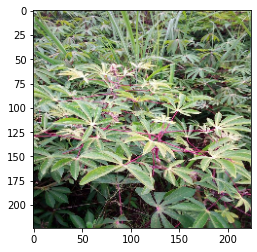

In [10]:
dataset_test = tf.data.Dataset.from_tensor_slices((submission.values, target_test)) #$note: no targets really  #class tensorflow.python.data.ops.dataset_ops.TensorSliceDataset

#for feat, targ in dataset_test.take(1):
#    print ('Features: {}, Target: {}'.format(feat, targ)) #class 'tensorflow.python.framework.ops.EagerTensor'
    
for feat, targ in dataset_test.take(1):
    print ('Features: {}'.format(feat)) #class 'tensorflow.python.framework.ops.EagerTensor'
    plt.imshow(my_preprocess_fn_test(feat[0])) #, aspect='auto'

In [11]:
#troubleshoot shapes
dataset_test

<TensorSliceDataset shapes: ((1,), ()), types: (tf.string, tf.int64)>

### 1.2 Batch Preprocess
#### With Iterator 
$note: works like without, cleaner tuple pieces

In [12]:
batch_test = dataset_test.map(my_preprocess_fn2_test).batch(BATCH_SIZE).as_numpy_iterator() #class tensorflow.python.data.ops.dataset_ops._NumpyIterator
#preview: in each batch look at some features and targets (class tf.Tensor)
for x,y in batch_test:
    print(x[0,2,2])

[0.85394156 0.8692077  0.8691777 ]


## 2. myModel

Let's load the classifier from TF-Hub and get some predictions and see the predictions of the model is on a few examples

In [13]:
#load the classifier model from TFHub
#was with Internet
#URL = 'https://tfhub.dev/google/cropnet/classifier/cassava_disease_V1/2'

import os
os.listdir("../input/cassava-leaf-disease-1st-place-models/cropnet_mobilenetv3/cropnet/")

['variables', 'saved_model.pb']

In [14]:
model_path = "../input/cassava-leaf-disease-1st-place-models/cropnet_mobilenetv3/cropnet"
model = tfhub.KerasLayer(tf.saved_model.load(model_path))
model.__class__


tensorflow_hub.keras_layer.KerasLayer

## 3. Predict

### 3a. Predict One Image
Test ds - only one file

['../input/cassava-leaf-disease-classification/test_images/2216849948.jpg']


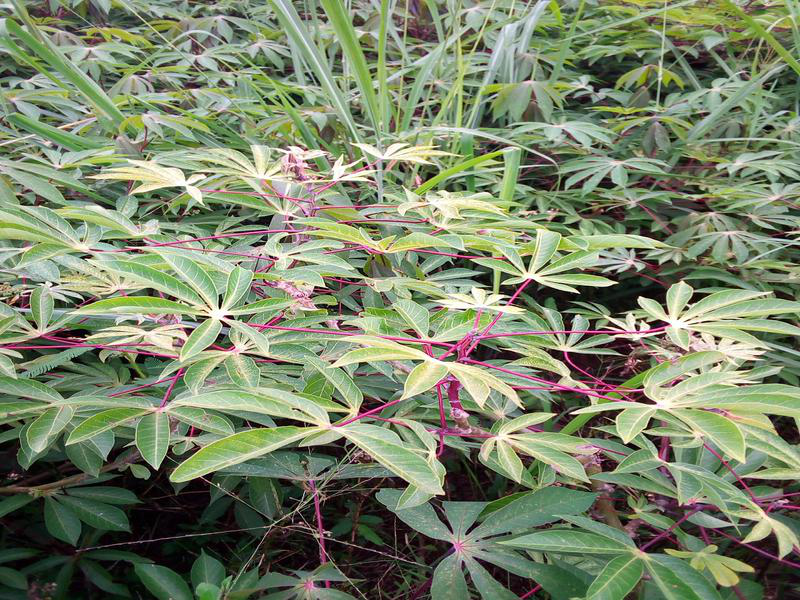

In [15]:
#view test images - only one
#test_img = get_image_files(path/'test_images')
#Image.open(test_img[0])

#create test images id
test_img_id = [os.path.join(DIR_TEST, x) for x in submission['image_id'].values]
print(test_img_id)
Image.open(test_img_id[0])

In [16]:
test_image = my_preprocess_fn_test(submission.loc[0,'image_id']) #class tensorflow.python.framework.ops.EagerTensor
test_image.shape

TensorShape([224, 224, 3])

In [17]:
#Predict on one image (in list)
probabilities = model(np.array([test_image])) #$note: list with one image
predictions = tf.argmax(probabilities, axis=-1)
probabilities, predictions

(<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
 array([[3.3328049e-03, 1.5064594e-02, 7.5062138e-01, 1.1662780e-03,
         2.2981326e-01, 1.6655039e-06]], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=int64, numpy=array([2])>)

### 3b. Predict on Test Data
Predict on real test ds: on test image(s) in batch(es)

In [18]:
preds = []

#mine - iterate over batches
batch_test = dataset_test.map(my_preprocess_fn2_test).batch(BATCH_SIZE).as_numpy_iterator()
for x,y in batch_test:
    probabilities = model(x)
    predictions = tf.argmax(probabilities, axis=-1)
    preds.append(np.array(predictions))
    
#show last batch
predictions

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([2])>

In [19]:
#add predictions to submission
submission['label'] = np.concatenate( preds, axis=0 )
submission.head()

,image_id,label
0,2216849948.jpg,2


## 4. Submit to Kaggle

In [20]:
#save to csv
submission.to_csv('submission.csv', index=False)

## Learn more

* Learn more about the model on TensorFlow Hub: https://tfhub.dev/google/cropnet/classifier/cassava_disease_V1/2
* Learn how to build a custom image classifier running on a mobile phone with [ML Kit](https://developers.google.com/ml-kit/custom-models#tfhub) with the [TensorFlow Lite version of this model](https://tfhub.dev/google/lite-model/cropnet/classifier/cassava_disease_V1/1).

## Xtra

In [21]:
mystop

NameError: name 'mystop' is not defined

In [22]:
#transform train images, return w/o label
def my_preprocess_fn(data):
    #print(data.__class__)
    #print(data)
    image_string = tf.io.read_file(DIR_TRAIN + data)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    # Normalize [0, 255] to [0, 1]
    image = tf.cast(image_decoded, tf.float32)
    image = image / 255.
    # Resize the images to 224 x 224
    image = tf.image.resize(image, IMAGE_SHAPE)
    
    return image

#transform train images, return with label
def my_preprocess_fn2(data, label):
    #print(data.__class__)
    #print(data)
    image_string = tf.io.read_file(DIR_TRAIN + data[0])
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    # Normalize [0, 255] to [0, 1]
    image = tf.cast(image_decoded, tf.float32)
    image = image / 255.
    # Resize the images to 224 x 224
    image = tf.image.resize(image, IMAGE_SHAPE)
    
    return image, label